### 로지스틱 회귀

In [3]:
# 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand, multivariate_normal

# 데이터 프레임 경고 없애기
# pd.options.mode.chained_assignment = None

### **01. 로지스틱 함수 시각화**


<ipython-input-4-b7c67a59ec7f>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


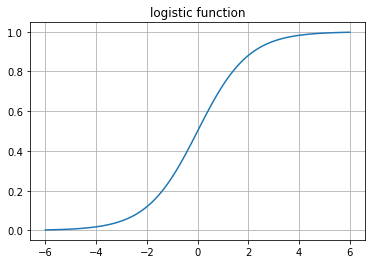

In [4]:
# 로지스틱 함수 시각화
x = np.linspace(-6,6,101) 
y = 1.0/(1.0+np.exp(-x)) # 로지스틱 함수

fig, ax = plt.subplots()
ax.set_title("logistic function")
ax.grid(True)
ax.plot(x,y)
fig.show()

### **02. 트레이닝 셋 생성**

In [5]:
# 데이터 셋({x_n, y_n, type_n}) 만드는 함수(prepare_dataset) 선언하기
# 개수가 N = N0+N1 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
#
# parameters = {
#     "N0": t = 0인 데이터 개수},
#     "Mu0": t = 0인 데이터 중심 (x,y) 좌표,
#     "N1": t = 1인 데이터 개수,
#     "Mu1": t = 1인 데이터 중심 (x,y) 좌표
# }

def prepare_dataset(parameters, variance):
    N0 = parameters["N0"]  # t = 0인 데이터 개수
    Mu0 = parameters["Mu0"] # t = 0인 데이터 중심 (x,y) 좌표
    N1 = parameters["N1"] # t = 1인 데이터 개수
    Mu1 =  parameters["Mu1"] # t = 1인 데이터 중심 (x,y) 좌표

    # 공분산 행렬 C = [[Var(X),Cov(X,Y)], [Cov(Y,X),Var(Y)]
    # Var(X): X축 분산, Var(Y): Y축 분산
    # Cov(X,Y) = 0, Cov(Y,X) = 0인 공분산. 두 변수 X, Y는 서로 독립적. 
    # 공분산이 0이고 X축, Y축 분산이 같음
    cov1 = np.array([[variance,0],[0,variance]])
    cov2 = np.array([[variance,0],[0,variance]])

    # t=+1인 데이터 생성
    df1 = pd.DataFrame(multivariate_normal(Mu1,cov1,N1),columns=['x','y'])
    df1['t'] = 1
    # t=-1인 데이터 생성
    df2 = pd.DataFrame(multivariate_normal(Mu0,cov2,N0),columns=['x','y'])
    df2['t'] = 0
    
    # 생성된 데이터 합치기
    df = pd.concat([df1,df2],ignore_index=True)

    # df에 index를 랜덤으로 섞기
    df = df.reindex(np.random.permutation(df.index))
    
    # df에 index를 처음부터 다시 라벨링하기 
    # drop = True는 새로운 index를 추가로 만들지 않게 하기 위해서
    df = df.reset_index(drop=True)
    
    return df

<ipython-input-6-c93f6cf80a88>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


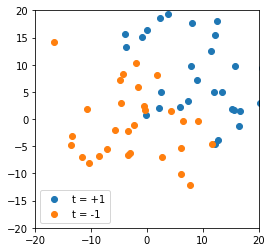

In [6]:
# 파라미터 
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
sample_parameters = {
    "N0": 30, # t = 0인 데이터 개수
    "Mu0": [-3,-3], # t = 0인 데이터 중심 (x,y) 좌표
    "N1": 30, # t = 1인 데이터 개수
    "Mu1": [7,7], # t = 1인 데이터 중심 [x,y] 좌표
}

df = prepare_dataset(sample_parameters, 50)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.scatter(df[df["t"]==1].x, df[df["t"]==1].y, label="t = +1")
ax.scatter(df[df["t"]==0].x, df[df["t"]==0].y, label="t = -1")
ax.legend()
fig.show()

In [39]:
def fit_perceptron(training_set, iteration_num, bias=None):
    def calc_stochastic_gradient_descent_w(w):
        # 확률적 기울기 하강
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            t = t*2-1
            phi = np.array([c, x, y]).reshape(-1, 1)
            if np.dot(w.T, phi) * t <= 0:
                w = w + t * phi  # w_new = w_old + t_n * phi_n
        return w

    def calc_error_rate():
        # 잘못 분류된 데이터 비율(%) 계산하기
        # err_num: 잘못된 데이터 개수
        err_num = 0
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            t = t*2-1
            phi = np.array([c, x, y]).reshape(-1, 1)
            if np.dot(w.T, phi) * t <= 0:
                err_num += 1
        err_rate = err_num / len(training_set) * 100

        return err_rate
    def calc_error():
        # 잘못 분류된 데이터 비율(%) 계산하기
        # err_num: 잘못된 데이터 개수
        err = 0
        for _, data in training_set.iterrows():
            x, y, t = data.x, data.y, data.t
            phi = np.array([c, x, y]).reshape(-1, 1)
            t = t*2-1
            if np.dot(w.T, phi) * t <= 0:
                err_vector = np.dot(w.T, phi) * t * -1
                err += err_vector.flatten()[0]
        return err

    # c는 bias항
    c = 0
    if bias is None:
        c = 0.5 * (training_set.x.mean() + training_set.y.mean())
    else:
        c = bias

    # w 초기값 설정하기
    w = np.array([np.random.rand(),np.random.rand(),np.random.rand()]).reshape(-1, 1)

    # parameter와 error rate를 기록하기 위한 DataFrame 선언
    w_hist = pd.DataFrame([w.flatten()], columns=["w0", "w1", "w2"])
    err_rate_hist = pd.DataFrame([], columns=["err_rate"])
    err_hist = pd.DataFrame([], columns=["err"])

    for i in range(iteration_num):
        w = calc_stochastic_gradient_descent_w(w)
        w_hist = w_hist.append(
            pd.Series(w.flatten(), index=["w0", "w1", "w2"]), ignore_index=True
        )

        err_rate = calc_error_rate()
        err_rate_hist = err_rate_hist.append(
            pd.Series(err_rate, index=["err_rate"]), ignore_index=True
        )

        err = calc_error()
        err_hist = err_hist.append(
            pd.Series(err, index=["err"]), ignore_index=True
        )
    result = {"w": w, "err_rate": err_rate, "bias": c}

    return result, w_hist, err_rate_hist, err_hist

$
z = \sigma (a) = \sigma (\mathbf{w}^T \mathbf{\Phi})
\\
\mathbf{w}_{new} = \mathbf{w}_{old} - (\mathbf{\Phi}^T \mathbf{R} \mathbf{\Phi})^{-1} \mathbf{\Phi}^T (\mathbf{z} - \mathbf{t})
\\
\mathbf{t}=\begin{pmatrix} t_1 \\\\ \vdots \\\\ t_N \end{pmatrix}, \mathbf{\Phi} = \begin{pmatrix} 1 & x_1 & y_1 \\\\ 1 & x_2 & y_2 \\\\ \vdots & \vdots & \vdots \\\\ 1 & x_N & y_N \end{pmatrix}, \mathbf{z}=\begin{pmatrix} z_1 \\\\ \vdots \\\\ z_N \end{pmatrix}, \mathbf{R}= \begin{pmatrix} z_1 (1 - z_1) &  & 0 \\\\  & \ddots & \\\\ 0 &  & z_N (1 - z_N) \end{pmatrix}  $

In [56]:
# 결과를 시각화 하는 함수들

#트레이닝 셋 시각화
def plot_training_data(training_set,ax):
    training_set1 = training_set[training_set['t']==1] # t=1인 트레이닝 셋
    training_set2 = training_set[training_set['t']==0] # t=0인 트레이닝 셋
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    ax.set_xlim([xmin-1, xmax+1])
    ax.set_ylim([ymin-1, ymax+1])
    ax.scatter(training_set1.x, training_set1.y, marker='o')
    ax.scatter(training_set2.x, training_set2.y, marker='x')

# 퍼셉트론을 사용한 결과 시각화
def plot_peceptron_graph(training_set, parameters, ax): 
    w0 = parameters["w"][0]
    w1 = parameters["w"][1]
    w2 = parameters["w"][2]
    bias = parameters["bias"]
    err_rate = parameters["err_rate"]
   
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex, liney, label=label, color='red', linestyle='--')
    ax.legend(loc=1)

# 로지스틱 회귀분석을 사용한 결과 시각화
def plot_logistic_regression_graph(training_set,parameters, ax):
    w0 = parameters["w"][0]
    w1 = parameters["w"][1]
    w2 = parameters["w"][2]
    err_rate = parameters["err_rate"]
    
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex,liney ,label=label, color='blue')
    ax.legend(loc=1)

In [57]:
# 파라미터 
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
initial_parameters = {
    "N0": 30, # t = 0인 데이터 개수
    "Mu0": [-3,-3], # t = 0인 데이터 중심 (x,y) 좌표
    "N1": 30, # t = 1인 데이터 개수
    "Mu1": [7,7], # t = 1인 데이터 중심 [x,y] 좌표
}
variance_list = [5,10,30,50] # 양 클래스 공통의 분산(4종류의 분산으로 계산 실시)
iteration_num = 30

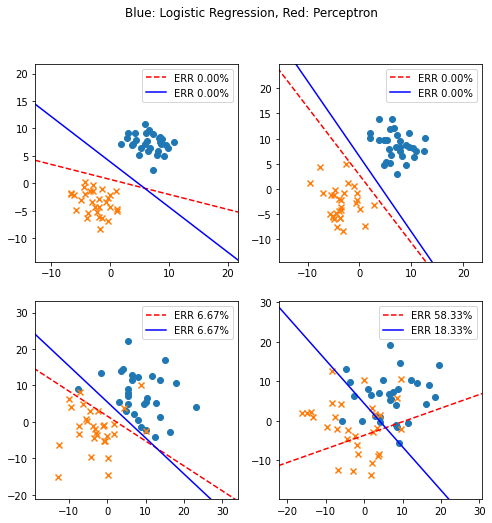

In [88]:
def fit_logistics_regression(training_set, iteration_num, bias=None):    
    def calc_phi():
        phi =  training_set[['x','y']]
        phi['bias'] = 1
        phi = phi[["bias","x","y"]] # phi의 열순서를 "bias", "x", "y"순으로 변경
        phi = phi.values # datafame phi를 ndarray로 변환       
        return phi
    
    def calc_t():
        t = training_set[['t']] # training_set의 "t"열을 t에 대입
        t = t.values # dataframe t를 ndarray로 변환
        return t

    def calc_IRLS(w, t, phi):
        z = np.array([])
        for line in phi:
            a = np.dot(w.T, line)
            z = np.append(z,[1.0/(1.0+np.exp(-a))])
        R = np.diag(z*(1-z))
        z = z.reshape(-1,1)
        tmp1 = np.linalg.inv(np.linalg.multi_dot([phi.T, R,phi]))
        tmp2 = np.dot(phi.T, (z-t))
        w_new = w_old - np.dot(tmp1, tmp2)
        
        return w_new

    def calc_err_rate(w):
        err_num = 0
        for _, point in training_set.iterrows():
            x, y, t = point.x, point.y, point.t
            t = t * 2 - 1
            if t * (w[0] + w[1]*x + w[2]*y) < 0:
                err_num += 1
        err_rate = err_num * 100 / len(training_set)
        return err_rate


    phi = calc_phi()
    t = calc_t()
    w_old = np.array([[0.],[0.],[0.]])

    for i in range(iteration_num):
        w_new = calc_IRLS(w_old, t, phi)
       
        if np.dot((w_new-w_old).T, (w_new-w_old)) < 0.001 * np.dot(w_old.T, w_old):
            # 파라미터의 변화가 0.1% 미만이 되면 종료
            break
       
        w_old = w_new
    err_rate = calc_err_rate(w_new)

    #TODO Err 구하는 식
    
    result = {
        "w": w_new,
        "err_rate": err_rate,
    }

    return result

fig,axs = plt.subplots(2,2,figsize=(8,8))
fig.suptitle('Blue: Logistic Regression, Red: Perceptron')
for c, variance in enumerate(variance_list):
    # 시각화 할 그래프 그리드 위치 설정
    ax = axs[int(c/2),c%2]

    # 트레이닝 셋 생성
    training_set = prepare_dataset(initial_parameters, variance)

    # 트레이닝 셋 시각화
    plot_training_data(training_set,ax)
    # 퍼셉트론을 사용하여 계산 및 시각화
    perceptron_parameters, _, _, _ = fit_perceptron(training_set,iteration_num)
    plot_peceptron_graph(training_set, perceptron_parameters, ax)

    # 로지스틱 회귀 분석을 사용하여 계산 및 시각화
    logistic_parameters = fit_logistics_regression(training_set, iteration_num)
    plot_logistic_regression_graph(training_set,logistic_parameters, ax)

<ipython-input-95-e853bf5bfb14>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


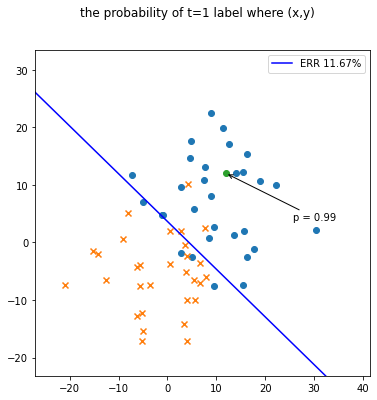

In [95]:
# x,y위치 값이 t=1라벨로 분류될 확률 계산하기
variance = 60
x,y = (12,12)


fig,ax = plt.subplots(1,1,figsize=(6,6))
fig.suptitle("the probability of t=1 label where (x,y)")

# 시각화 할 그래프 그리드 위치 설정
# 트레이닝 셋 생성
training_set = prepare_dataset(initial_parameters, variance)

# 트레이닝 셋 시각화
plot_training_data(training_set,ax)

# 로지스틱 회귀 분석을 사용하여 계산 및 시각화
logistic_parameters = fit_logistics_regression(training_set, iteration_num)
plot_logistic_regression_graph(training_set,logistic_parameters, ax)

ax.scatter(x,y)

w = [logistic_parameters["w"][0],logistic_parameters["w"][1],
     logistic_parameters["w"][2]]

a = np.dot(np.array([1, x, y]), w)
probability = 1.0/(1.0+np.exp(-a))
ax.annotate('p = %.2f'%(probability), xy=(x, y),  xycoords='data',
            xytext=(0.9, 0.5), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->'),
            horizontalalignment='right', verticalalignment='top',
            )

fig.show()

### ROC 곡선

In [100]:
# ROC 계산 
# ROC: Receiver Operating Caracteristic
def calc_roc(training_set, parameter):
    # 각 데이터 확률 계산
    w =  [parameter["w"][0], parameter["w"][1], parameter["w"][2]]
    training_set['probability'] = 0.0
    err = 0
    for index, line in training_set.iterrows():
        a = np.dot(np.array([1, line.x, line.y]), w)
        p = 1.0/(1.0+np.exp(-a))
        training_set.loc[index, 'probability'] = p
        if (p-0.5)*(line.t*2-1) < 0:
            err += 1
    err_rate = err * 100 / len(training_set)
    result = training_set.sort_values(by=['probability'], ascending=[False]).reset_index(drop = True)

    # 진양성률 및 위양성률 계산
    # n(데이터 인덱스): [0,1, ... n ... ,N-1]
    # t(데이터 속성): [t_1, t_2, ... t_n ... , t_N-1]
    # 확률: [probability_1, probabilty_2, ... probability_n  ... , probability_N]
    positives = len(result[result['t']==1]) # 양성 데이터 개수
    negatives = len(result[result['t']==0]) # 음성 데이터 개수
    tp = [0.0] * len(result) 
    fp = [0.0] * len(result) 

    # index가 n일 때  확률이 probabilty_n보다 큰지가 판단 기준
    # 데이터가 정렬되어 있기 때문에, n보다 낮은 index에서는 항상 p값이 더 높음
    for n, line in result.iterrows():
        for c in np.arange(0,n):
            if result.t[c] == 1:
                tp[n] += 1
            else:
                fp[n] += 1
        
    tp_rate = np.array(tp) / positives # tp_rate(진양성률): true positive
    fp_rate = np.array(fp) / negatives # fp_rate(위양성률): false positive
    result = {
        "tp_rate": tp_rate,
        "fp_rate": fp_rate
    }

    return result

In [107]:
def plot_training_set(training_set, parameter, ax):
    w0 = parameter["w"][0]
    w1 = parameter["w"][1]
    w2 = parameter["w"][2]
    err_rate = parameter["err_rate"]

    training_set1 = training_set[training_set['t']==1]
    training_set2 = training_set[training_set['t']==0]
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    ax.set_ylim([ymin-1, ymax+1])
    ax.set_xlim([xmin-1, xmax+1])

    # 분류 데이터 표시
    ax.scatter(training_set1.x, training_set1.y, marker='o')
    ax.scatter(training_set2.x, training_set2.y, marker='x')

    # P=0.5인 직선을 표시
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex,liney ,label=label, color='blue')
    ax.legend(loc=1)

# ROC곡선표시
def plot_roc_curve(training_set, result, ax):
    tp_rate = result["tp_rate"]
    fp_rate = result["fp_rate"]
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.plot(fp_rate, tp_rate)

In [108]:
# 파라미터 
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
initial_parameters = {
    "N0": 200, # t = 0인 데이터 개수
    "Mu0": [-3,-3], # t = 0인 데이터 중심 (x,y) 좌표
    "N1": 80, # t = 1인 데이터 개수
    "Mu1": [9,9], # t = 1인 데이터 중심 (x,y) 좌표
}

variance_list = [80,200] # 양 클래스 공통의 분산(2종류의 분산으로 계산 실시)

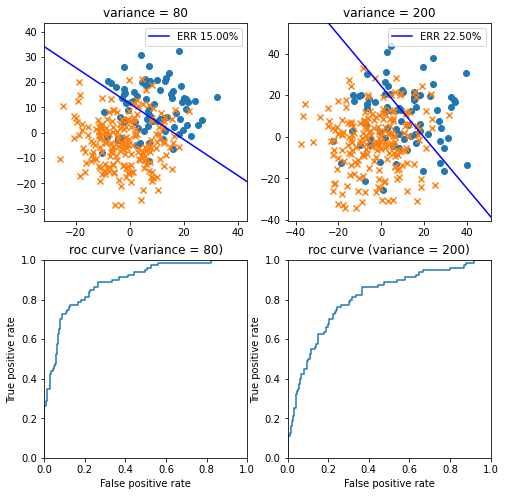

In [109]:
# 로지스틱을 이용한 분류 시각화 및 ROC 곡선 시각화
fig,axs = plt.subplots(2,2,figsize=(8,8))
for c, variance in enumerate(variance_list):    
    training_set = prepare_dataset(initial_parameters, variance)
  
    # 로지스틱 분류 계산 및 시각화
    parameter = fit_logistics_regression(training_set,100)
    plot_training_set(training_set,parameter, axs[0,c])
    axs[0,c].set_title("variance = %d"%(variance))
 
    # ROC 곡선 계산 및 시각화
    result = calc_roc(training_set,parameter)
    plot_roc_curve(training_set, result, axs[1,c])
    axs[1,c].set_title("roc curve (variance = %d)"%(variance)) 